Для удобства, чтобы каждые раз не перезапускать очистку признаков, я перезаписала данные ыв новый файл data_clean.csv. Кодирование, стандартизация нормализация, и дальнейший анализ будем проводить уже с ней

In [75]:
# загружаем необходимые библиотеки 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder #кодирование
from sklearn.preprocessing import MinMaxScaler # нормализация
from sklearn.feature_selection import f_classif  # оценка значимости
import matplotlib.pyplot as plt # визуализация
from sklearn.feature_selection import mutual_info_regression # оценка значимости
from sklearn.model_selection import train_test_split
from sklearn import metrics
# модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection
import optuna
from optuna.integration import SkoptSampler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import optuna.distributions as dist
from sklearn.model_selection import GridSearchCV
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNetCV
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb
import time

In [27]:
# Читаем документ
df = pd.read_csv('/home/tatiana/Документы/DS SkillFactory/ДИПЛОМ/data_clean.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292597 entries, 0 to 292596
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           292597 non-null  object 
 1   propertyType     292597 non-null  object 
 2   fireplace        292597 non-null  int64  
 3   sqft             292597 non-null  float64
 4   zipcode          292597 non-null  int64  
 5   beds             292597 non-null  float64
 6   state            292597 non-null  object 
 7   stories          292597 non-null  float64
 8   PrivatePool      292597 non-null  float64
 9   MlsId            292597 non-null  int64  
 10  target_per_sqft  292597 non-null  float64
 11  Heating          292597 non-null  object 
 12  Cooling          292597 non-null  object 
 13  Parking          292597 non-null  object 
 14  compare_built    292597 non-null  int64  
 15  len_rating       292597 non-null  float64
dtypes: float64(6), int64(4), object(6)
mem

Напомним, что обозначает каждый из этих признаков:
- status - статус продажи
- propertyType - тип недвижимости
- fireplace - наличие камина 0 или 1
- sqft - площадь объекта в футах
- zipcode - индекс
- beds количество спален
- state - штат 
- stories - количество этажей
- PrivatePool - наличие бассейна 0 или 1
- MlsId  - есть ли объект в базе мультилистинга 0 или 1
- target_per_sqft - стоимость за квадратный фут (целевой)
- Parking - парковка 
- compare_built - была ли реставрация
- len_rating - количество школ рядом (по рейтингу)
- Heating - наличие отопления
- Cooling - наличие вентиляции и кондиционера


### ПЛАН ДЕЙСТВИЙ

Для создания модели, предсказывающей стоимость квадратного метра, требуются следующие шаги:

1. Подготовка данных:
   - Кодирование категориальных признаков: Категориальные признаки, такие как status, propertyType, state и другие, нужно закодировать числовыми значениями, чтобы модель могла их использовать. 
   - оценка корреляции с целевым признаком и друг с другом. Определение наиболее значимых признаков


2. Выбор модели:
   - Учитывая, что требуется предсказывать стоимость квадратного метра, можно рассмотреть модели регрессии, такие как линейная регрессия, регрессия случайного леса (Random Forest Regression) или градиентный бустинг (Gradient Boosting).
   - При выборе модели также можно учесть размер данных и время, необходимое для обучения и предсказания. Некоторые модели могут быть более подходящими для больших наборов данных, в то время как другие могут быть более эффективными для быстрого обучения и предсказания.

3. Оценка и настройка модели:
   - Разделить данные на обучающую и тестовую выборки. Обучите модель на обучающей выборке и оцените ее производительность на тестовой выборке.
   - Использовать метрики оценки регрессии, такие как среднеквадратичная ошибка (Mean Squared Error) или коэффициент детерминации (R-squared), чтобы оценить точность модели.
   - Если модель демонстрирует недостаточную производительность, можно попробовать настроить гиперпараметры модели или использовать методы регуляризации для улучшения результатов.

4. Проверка и интерпретация модели:
   - После обучения и оценки модели важно проверить ее на новых данных или на реальных сценариях. Это поможет убедиться, что модель работает правильно и может быть применена на практике.
   
Важно помнить, что выбор модели и создание признаков зависит от специфики данных и поставленной задачи. Для лучших результатов необходимо провести дополнительный анализ данных и эксперименты с различными моделями и признаками.

### 1. Кодирование категориальных признаков

In [29]:
# переводим индекс в категориальный, в прошлом этапе мы его сделали числовым, чтобы убрать нули
df['zipcode'] = df['zipcode'].astype(str)

In [30]:
# числовые признаки 
fig_features = ['fireplace', 'sqft', 'beds', 'stories', 'PrivatePool', 'MlsId', 'compare_built', 'len_rating']
# категориальные признаки 
cat_features = ['status', 'propertyType', 'zipcode', 'state', 'Heating', 'Cooling', 'Parking']

In [31]:
# подсчет количества уникальных значений в категориальном признаке
for col in cat_features:
   unique_values = df[col].nunique()
   print(f"Уникальных значений в {col}: {unique_values}")

Уникальных значений в status: 7
Уникальных значений в propertyType: 12
Уникальных значений в zipcode: 4088
Уникальных значений в state: 34
Уникальных значений в Heating: 4
Уникальных значений в Cooling: 4
Уникальных значений в Parking: 6


1. 'status' (7 уникальных значений), 'propertyType' (12 уникальных значений), 'Heating' (4 уникальных значений), 'Cooling' (4 уникальных значений), 'Parking' (6 значений) - Поскольку значения являются категориальными и неупорядоченными, использовать метод "one-hot encoding" (бинарное кодирование).

2. 'zipcode' (4088 уникальных значений), 'state' (34 уникальных значений)- закодируем LabelEncoder:

In [32]:
# кодирование one-hot encoding
ohe_cols = ['status', 'propertyType','Heating', 'Cooling', 'Parking']
ohe_encoder = OneHotEncoder(sparse=False)
ohe_encoded = ohe_encoder.fit_transform(df[ohe_cols])
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_encoder.get_feature_names_out(ohe_cols))

# Простое кодирование для city и zipcode
le_encoder = LabelEncoder()
df['state_encoded'] = le_encoder.fit_transform(df['state'])
df['zipcode_encoded'] = le_encoder.fit_transform(df['zipcode'])


# Удаление исходных колонок
df.drop(['zipcode', 'status', 'propertyType', 'state', 'Heating', 'Cooling', 'Parking'], axis=1, inplace=True)

# Объединение закодированных признаков с исходным DataFrame
encoded_df = pd.concat([df, ohe_df], axis=1)
encoded_df.info()

/home/tatiana/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292597 entries, 0 to 292596
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   fireplace                   292597 non-null  int64  
 1   sqft                        292597 non-null  float64
 2   beds                        292597 non-null  float64
 3   stories                     292597 non-null  float64
 4   PrivatePool                 292597 non-null  float64
 5   MlsId                       292597 non-null  int64  
 6   target_per_sqft             292597 non-null  float64
 7   compare_built               292597 non-null  int64  
 8   len_rating                  292597 non-null  float64
 9   state_encoded               292597 non-null  int64  
 10  zipcode_encoded             292597 non-null  int64  
 11  status_Coming soon          292597 non-null  float64
 12  status_Contingent           292597 non-null  float64
 13  status_For sal

### 2. Нормализация 

В случае задачи предсказания стоимости квадратного метра, где минимальное значение составляет 20, а максимальное значение равно 2000, нормализация целевого признака может быть полезной.

Нормализация целевого признака поможет привести его значения к общему масштабу и уменьшить влияние выбросов или различных единиц измерения. Это может быть особенно полезно для алгоритмов машинного обучения, которые чувствительны к различным масштабам значений признаков, например, линейной регрессии.

Однако важно отметить, что нормализация целевого признака может изменить его интерпретацию и влиять на результаты предсказания. Например, если используется линейная регрессия и необходимо получить конкретные значениями стоимости квадратного метра, то нормализация может затруднить интерпретацию результатов.
Поэтому, мы будем нормализовывать все признаки, кроме целевого. 

Используем `MinMaxscaler`.

In [33]:
# разделим датасет на X - матрица наблюдений, y - столбец правильных ответов
X = encoded_df.drop('target_per_sqft', axis=1)
y = encoded_df['target_per_sqft']

In [34]:
# Создаем экземпляр стандартного шкалировщика
scaler = MinMaxScaler()
# Применяем шкалирование к данным
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [35]:
X_scaled

,fireplace,sqft,beds,stories,PrivatePool,MlsId,compare_built,len_rating,state_encoded,zipcode_encoded,...,Cooling_central,Cooling_individual,Cooling_no,Cooling_other,Parking_assigned,Parking_boat,Parking_carport,Parking_garage,Parking_parking,Parking_street
0,1.0,0.275862,0.571429,0.013333,0.0,1.0,0.0,0.123077,0.545455,0.192317,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.174748,0.428571,0.013333,0.0,1.0,0.0,0.046154,0.969697,0.998287,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.286472,0.428571,0.013333,1.0,1.0,1.0,0.046154,0.030303,0.792268,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.653263,0.714286,0.013333,0.0,1.0,0.0,0.061538,0.848485,0.569366,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.063342,0.285714,0.026667,0.0,1.0,0.0,0.000000,0.757576,0.104722,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292592,0.0,0.118515,0.285714,0.026667,0.0,1.0,0.0,0.030769,0.090909,0.108882,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
292593,0.0,0.394377,0.714286,0.013333,1.0,1.0,0.0,0.030769,0.151515,0.279667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
292594,0.0,0.180371,0.428571,0.026667,0.0,1.0,0.0,0.046154,0.242424,0.526058,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
292595,0.0,0.090398,0.428571,0.026667,0.0,0.0,0.0,0.030769,0.636364,0.046978,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Корреляция и оценка значимости признаков

In [36]:
# выделим пары сильно скоррелированных признаков (более 0.8)
corr_matrix = encoded_df.corr().abs()
high_corr_var_pairs_hight= [(corr_matrix.columns[i], corr_matrix.columns[j]) for i in range(len(corr_matrix.columns)) for j in range(i+1, len(corr_matrix.columns)) if corr_matrix.iloc[i,j] > 0.8]

print(high_corr_var_pairs_hight)

[('Cooling_central', 'Cooling_no')]


In [37]:
# выделим пары слабо скоррелированных признаков (менее 0.05)
corr_matrix =encoded_df.corr().abs()
high_corr_var_pairs_low = [(corr_matrix.columns[i], corr_matrix.columns[j]) for i in range(len(corr_matrix.columns)) for j in range(i+1, len(corr_matrix.columns)) if corr_matrix.iloc[i,j] < 0.05]

len(high_corr_var_pairs_low)

652

Видим, что у нас довольно монго данных, которые оказывают очень маленькое влияние на целевой признак

In [38]:
correlations = pd.DataFrame(X_scaled, columns=X.columns).corrwith(y).abs().sort_values(ascending=False)
correlations.head(15)

propertyType_Condo            0.294538
propertyType_SingleFamiily    0.238920
state_encoded                 0.183909
stories                       0.175687
propertyType_Coop             0.116057
PrivatePool                   0.108615
propertyType_Highlevel        0.085153
Heating_no                    0.084923
beds                          0.083484
propertyType_Manufactured     0.068954
Cooling_central               0.066652
len_rating                    0.059618
Heating_other                 0.058031
Cooling_no                    0.056450
propertyType_MultiFamily      0.053574
dtype: float64

Проведем оценку значимости признаков. Воспользуемся для оценки дисперсионным анализом ANOVA.

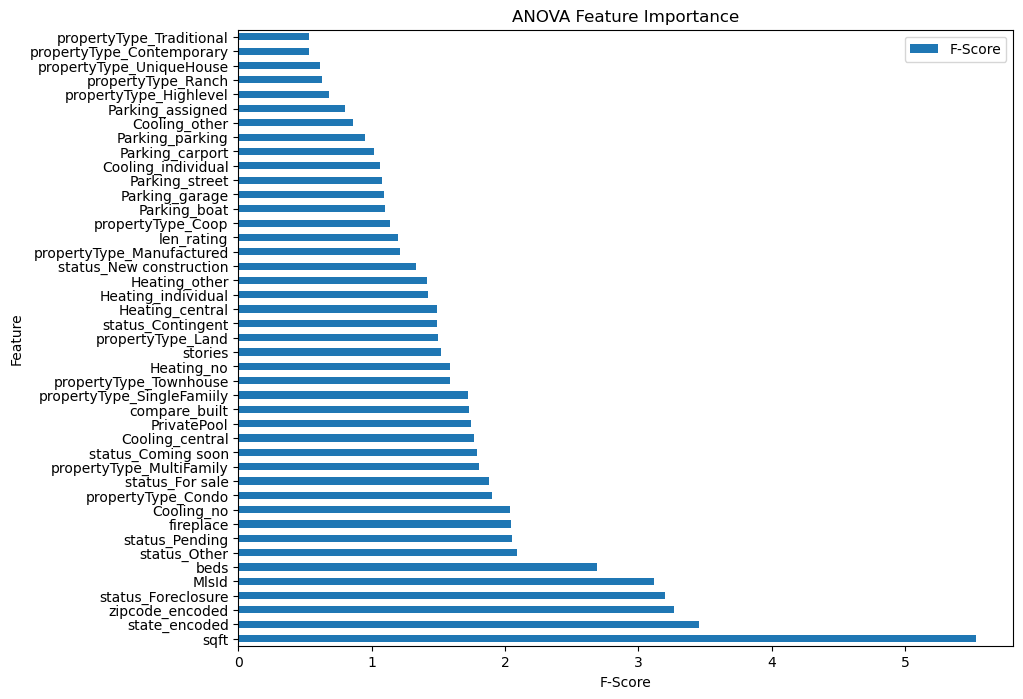

In [39]:
# Выполняем ANOVA для расчета значимости признаков
f_scores, p_values = f_classif(X_scaled, y)

# Создаем DataFrame с результатами ANOVA
anova_results = pd.DataFrame({'Feature': X_scaled.columns, 'F-Score': f_scores, 'p-value': p_values})

# Сортируем по F-Score в порядке убывания
anova_results.sort_values('F-Score', ascending=False, inplace=True)

# Визуализируем результаты анализа значимости
fig, ax = plt.subplots(figsize=(10, 8))
anova_results.plot(x='Feature', y='F-Score', kind='barh', ax=ax)
ax.set_xlabel('F-Score')
ax.set_ylabel('Feature')
ax.set_title('ANOVA Feature Importance')
plt.show()

Метод взаимной информации может оценить степень зависимости между признаками и целевой переменной, основываясь на теории информации.

In [40]:
# Вычислим взаимную информацию для каждого признака
mutual_info = mutual_info_regression(X_scaled, y)

# Создаем Series с результатами взаимной информации
feature_scores = pd.Series(mutual_info, index=X_scaled.columns).sort_values(ascending=False)

In [41]:
feature_scores.head(20)

sqft                          1.325377
zipcode_encoded               1.104336
state_encoded                 0.445145
beds                          0.168417
propertyType_SingleFamiily    0.091253
stories                       0.085591
len_rating                    0.082537
propertyType_Condo            0.080769
fireplace                     0.058904
Cooling_central               0.055610
Cooling_no                    0.051577
compare_built                 0.044227
Heating_central               0.041148
PrivatePool                   0.029497
Heating_no                    0.029207
MlsId                         0.029146
Heating_individual            0.024998
Heating_other                 0.019267
propertyType_Townhouse        0.019201
propertyType_MultiFamily      0.014273
dtype: float64

In [42]:
# выберем только 40 самых значимых признака для каждого метода из 50
correlation_features = correlations.abs().nlargest(35).index
anova_features = anova_results.nlargest(35, 'F-Score')['Feature']
mutual_info_features = feature_scores.nlargest(35).index

In [43]:
# Получение списка признаков, которые есть во всех трех методах
common_features = set(correlation_features) & set(anova_features) & set(mutual_info_features)

# Преобразование в список
common_features_list = list(common_features)

# Вывод списка признаков, присутствующих во всех трех методах
common_features_list

['Cooling_no',
 'status_For sale',
 'Heating_central',
 'Heating_individual',
 'Heating_other',
 'propertyType_MultiFamily',
 'stories',
 'zipcode_encoded',
 'propertyType_Condo',
 'status_Pending',
 'Cooling_individual',
 'Cooling_central',
 'sqft',
 'MlsId',
 'fireplace',
 'Parking_garage',
 'Parking_carport',
 'propertyType_Manufactured',
 'propertyType_Coop',
 'beds',
 'propertyType_SingleFamiily',
 'state_encoded',
 'status_Contingent',
 'propertyType_Townhouse',
 'Heating_no',
 'PrivatePool',
 'len_rating',
 'status_New construction',
 'status_Other',
 'Parking_street',
 'status_Foreclosure']

In [44]:
# длина списка
len(common_features_list)

31

In [45]:
# Создание нового DataFrame с отобранными признаками
X_best = pd.DataFrame(X_scaled, columns=X_scaled.columns)[common_features_list].copy()

Основной датасет содержит 44 признака, мы знаем, что значимость некоторых признаков очень низкая. Любая модель с таким количеством данных будет работать очень долго.  Я оценила значимость признаком тремя разными методами. Из каждого метода выбрала 35 самых значимых, а потом сравнила из между собой, получив только те, которые входят во все 3 метода. Их получилось 31. Перейдем к моделированию. 

- X_scaled  - содержит все признаки
- X_best - содержит только самые значимые
- y - столбец правильных ответов

Так же зафиксируем максимальную, минимальную и медианную стоимость за квадратный метр. Тогда нам проще будет интерпритировать ошибку MAE, которая как раз очень понятна, и показывает абсолютное отклонение в стоимости. 

In [46]:
df['target_per_sqft'].max(), df['target_per_sqft'].min(), round(df['target_per_sqft'].median(), 2)

(2000.0, 20.0, 176.87)

## Моделирование 

In [47]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
TEST_SIZE = 0.2

Выберем метрики для оценки качества модели: MSE (Mean Squared Error), MAE (Mean Absolute Error) и R2 (R-squared) - это метрики оценки качества моделей, которые используются в задачах регрессии. Вот их краткое описание:
1. MSE (Mean Squared Error): MSE измеряет среднеквадратичную ошибку между прогнозируемыми значениями модели и фактическими значениями. Она вычисляется путем возведения в квадрат разности между каждым прогнозируемым значением и соответствующим фактическим значением, а затем нахождения среднего значения этих квадратов. Более низкое значение MSE указывает на лучшую модель.

2. MAE (Mean Absolute Error): MAE измеряет среднюю абсолютную ошибку между прогнозируемыми значениями модели и фактическими значениями. Она вычисляется путем нахождения среднего значения абсолютных разностей между каждым прогнозируемым значением и соответствующим фактическим значением. Как и MSE, более низкое значение MAE указывает на лучшую модель

3. R2 (R-squared): R2-коэффициент, также известный как коэффициент детерминации, измеряет долю дисперсии зависимой переменной, которая может быть объяснена моделью. Он принимает значения от 0 до 1, где 0 означает, что модель не объясняет вариацию целевой переменной, а 1 означает, что модель полностью объясняет вариацию целевой переменной. 

In [89]:
# составим список метрик и моделей, куда будем вносить данные
data = {
    'Наименование модели': ['Линейная регрессия sklearn для всех признаков',
                            'Линейная регрессия с подбором гиперпараметров GridSearchCV',
                            'Линейная регрессия с подбором гиперпараметров Hyperopt',
                            'RandomForestRegressor',
                            'RandomForestRegressorCV',
                            'Gradient Boosting',
                            'Gradient Boosting на части факоров',
                            'ExtraTreesRegressor',
                            'AdaBoost', 
                            'LightGBM',
                            'LightGBM'],
    'Тип разделения': ['split 0.2', 'cv=5', 'split 0.2', 'split 0.2', 'cv=5', 'split 0.2', 'cv=5', 'split 0.2', 'split 0.2', 'split 0.2', 'cv=5'],
    'Гиперпараметры': ['Нет', 'GridSearchCV', 'Hyperopt', 'огранич.факторы', 'GridSearchCV', 'огранич.факторы', 'GridSearchCV', 'огранич. факторы', 'нет', 'нет', 'GridSearchCV'],
    'Train R2': [0.19, 0.19, 0.19, 0.69, 0.69, 0.39, 0.67, 0.69, 0.74, 0.65, 0.71],
    'Test R2': [0.20, 0.20, 0.20, 0.67, 0.67, 0.40, 0.66, 0.66, 0.69, 0.65, 0.68],
    'Train MSE': [42974.34, 42972.71, 42972.70, 16482.62, 16418.23, 24977.30, 17595.72, 16194.26, 13319.00, 18059.30, 15342.12],
    'Test MSE': [42651.24, 42648.95, 42649.08, 17598.63, 17695.45, 24973.00, 18011.88, 18229.49, 16363.19, 18508.24, 16759.69],
    'Train MAE': [130.73, 130.64, 130.65, 76.95, 76.69, 88.28, 77.95, 74.77, 65.33, 78.37, 71.77],
    'Test MAE': [130.35, 130.26, 130.27, 78.52, 78.48, 88.10, 78.36, 78.30, 71.43, 78.99, 73.91], 
    'Время работы(сек)': [0.4, 10.0, 43.5, 63.8, 2880, 37.9, 1276, 176.97, 32.7, 7.3, 52.4]
}
df = pd.DataFrame(data)
df

,Наименование модели,Тип разделения,Гиперпараметры,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Время работы(сек)
0,Линейная регрессия sklearn для всех признаков,split 0.2,Нет,0.19,0.20,42974.34,42651.24,130.73,130.35,0.40
1,Линейная регрессия с подбором гиперпараметров ...,cv=5,GridSearchCV,0.19,0.20,42972.71,42648.95,130.64,130.26,10.00
2,Линейная регрессия с подбором гиперпараметров ...,split 0.2,Hyperopt,0.19,0.20,42972.70,42649.08,130.65,130.27,43.50
3,RandomForestRegressor,split 0.2,огранич.факторы,0.69,0.67,16482.62,17598.63,76.95,78.52,63.80
4,RandomForestRegressorCV,cv=5,GridSearchCV,0.69,0.67,16418.23,17695.45,76.69,78.48,2880.00
5,Gradient Boosting,split 0.2,огранич.факторы,0.39,0.40,24977.30,24973.00,88.28,88.10,37.90
6,Gradient Boosting на части факоров,cv=5,GridSearchCV,0.67,0.66,17595.72,18011.88,77.95,78.36,1276.00
7,ExtraTreesRegressor,split 0.2,огранич. факторы,0.69,0.66,16194.26,18229.49,74.77,78.30,176.97
8,AdaBoost,split 0.2,нет,0.74,0.69,13319.00,16363.19,65.33,71.43,32.70
9,LightGBM,split 0.2,нет,0.65,0.65,18059.30,18508.24,78.37,78.99,7.30


Вывод по таблице: несмотря на небольшое переобучение, лучше всего проявила себы модель AdaBoost. 

In [49]:
# делим общую базу на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

Оценим метрики качества модели Линейная регрессия на всех признаках и зафиксируем результат.

## LinearRegression

In [50]:
# создаём модель линейной регрессии для общей базы model
model = LinearRegression()

# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)

# делаем предсказания с помощью модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# вычисляем требуемые метрики
mse_train1 = metrics.mean_squared_error(y_train, y_train_pred)
mse_test1 = metrics.mean_squared_error(y_test, y_test_pred)
mae_train1 = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test1 = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train1 = metrics.r2_score(y_train, y_train_pred)
r2_test1 = metrics.r2_score(y_test, y_test_pred)

# выводим метрики
print('Метрики для модели обученной на всех признаках')
print(f"Train MSE: {mse_train1:.2f}")
print(f"Test MSE: {mse_test1:.2f}")
print(f"Train MAE: {mae_train1:.2f}")
print(f"Test MAE: {mae_test1:.2f}")
print(f"Train R2: {r2_train1:.2f}")
print(f"Test R2: {r2_test1:.2f}")

Метрики для модели обученной на всех признаках
Train MSE: 42973.31
Test MSE: 42646.68
Train MAE: 130.65
Test MAE: 130.28
Train R2: 0.19
Test R2: 0.20


Вывод: качество модели низкое. 

## Линейная регрессия с подбором гиперпараметров GridSearchCV

In [51]:
# для модели  

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
y_train_pred_grid = grid_search.predict(X_train)
y_test_pred_grid = grid_search.predict(X_test)

mse_train = metrics.mean_squared_error(y_train, y_train_pred_grid)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred_grid)
r2_train = metrics.r2_score(y_train, y_train_pred_grid)

mse_test = metrics.mean_squared_error(y_test, y_test_pred_grid)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred_grid)
r2_test = metrics.r2_score(y_test, y_test_pred_grid)

print('MSE Train GridSearch: {:.2f}'.format(mse_train))
print('MAE Train GridSearch: {:.2f}'.format(mae_train))
print('R2 Score Train GridSearch: {:.2f}'.format(r2_train))

print('MSE Test GridSearch: {:.2f}'.format(mse_test))
print('MAE Test GridSearch: {:.2f}'.format(mae_test))
print('R2 Score Test GridSearch: {:.2f}'.format(r2_test))

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

MSE Train GridSearch: 42972.71
MAE Train GridSearch: 130.64
R2 Score Train GridSearch: 0.19
MSE Test GridSearch: 42648.95
MAE Test GridSearch: 130.26
R2 Score Test GridSearch: 0.20
Наилучшие значения гиперпараметров: {'fit_intercept': False, 'positive': False}


Модель с подбором гиперпараметров GridSearchCV показывает невысокую производительность, то же самое с RandomizedSearchCV - данные примерно те же самые не буду их сюда добавлять. Из продвинутых способов я добавлю только Hyperopt, т.к он быстрее работает и занимает меньше места в ноутбуке, и показывает результат лучше, чем Optuna.

## Линейная регрессия с подбором гиперпараметров Hyperopt

In [52]:
# для модели обученной на всех признаках 
def objective(params):
    model = linear_model.LinearRegression(**params)

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = metrics.mean_squared_error(y_train, y_train_pred)
    mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
    r2_train = metrics.r2_score(y_train, y_train_pred)

    mse_test = metrics.mean_squared_error(y_test, y_test_pred)
    mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
    r2_test = metrics.r2_score(y_test, y_test_pred)

    return {'loss': mse_test, 'status': STATUS_OK, 'mse_train': mse_train,
            'mae_train': mae_train, 'r2_train': r2_train,
            'mse_test': mse_test, 'mae_test': mae_test, 'r2_test': r2_test}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

space = {
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
    'positive': hp.choice('positive', [True, False]),
    'copy_X': hp.choice('copy_X', [True, False])
}

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

best_params = hyperopt.space_eval(space, best)
best_model = linear_model.LinearRegression(**best_params)
best_model.fit(X_train, y_train)
y_train_pred_hyperopt = best_model.predict(X_train)
y_test_pred_hyperopt = best_model.predict(X_test)

mse_train_hyperopt = metrics.mean_squared_error(y_train, y_train_pred_hyperopt)
mae_train_hyperopt = metrics.mean_absolute_error(y_train, y_train_pred_hyperopt)
r2_train_hyperopt = metrics.r2_score(y_train, y_train_pred_hyperopt)

mse_test_hyperopt = metrics.mean_squared_error(y_test, y_test_pred_hyperopt)
mae_test_hyperopt = metrics.mean_absolute_error(y_test, y_test_pred_hyperopt)
r2_test = metrics.r2_score(y_test, y_test_pred_hyperopt)

print('MSE Train Hyperopt: {:.2f}'.format(mse_train_hyperopt))
print('MAE Train Hyperopt: {:.2f}'.format(mae_train_hyperopt))
print('R2 Score Train Hyperopt: {:.2f}'.format(r2_train_hyperopt))

print('MSE Test Hyperopt: {:.2f}'.format(mse_test_hyperopt))
print('MAE Test Hyperopt: {:.2f}'.format(mae_test_hyperopt))
print('R2 Score Test Hyperopt: {:.2f}'.format(r2_test))


100%|██████████| 100/100 [00:46<00:00,  2.14trial/s, best loss: 42649.07581444097]
MSE Train Hyperopt: 42972.70
MAE Train Hyperopt: 130.65
R2 Score Train Hyperopt: 0.19
MSE Test Hyperopt: 42649.08
MAE Test Hyperopt: 130.27
R2 Score Test Hyperopt: 0.20


ВЫВОД: Линейная регрессия показывает не очень хорошие результаты. Это подтверждает данные корреляции - зависимость между целевым признаком и остальными очень слабая. Линейная регрессия не может уловить более сложные зависимости в данных. Немного лучше результаты показала можель обученная, но полиноминальных признаках, но и они недостаточно хороши, модель долго обучается, и есть переобучение. Кроме того, возможности компьютера не позволяют попробовать разные степени полинома. Воспроизводить их здесь не буду.  Рассмотрим другие модели. 

## RandomForestRegressor

In [53]:
# Создаем экземпляр модели RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=RANDOM_SEED, 
                                     n_estimators=100,  # Увеличение количества деревьев
                                     max_depth=10,  # Ограничение глубины деревьев
                                     min_samples_split=5,  # Минимальное количество образцов для разделения узла
                                     min_samples_leaf=2)  # Минимальное количество образцов в листе дерева

# Обучаем модель на обучающих данных
rf_regressor.fit(X_train, y_train)

# Предсказания на обучающих и тестовых данных
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 16482.62
Test MSE: 17598.63
Train MAE: 76.95
Test MAE: 78.52
Train R2: 0.69
Test R2: 0.67


<Axes: >

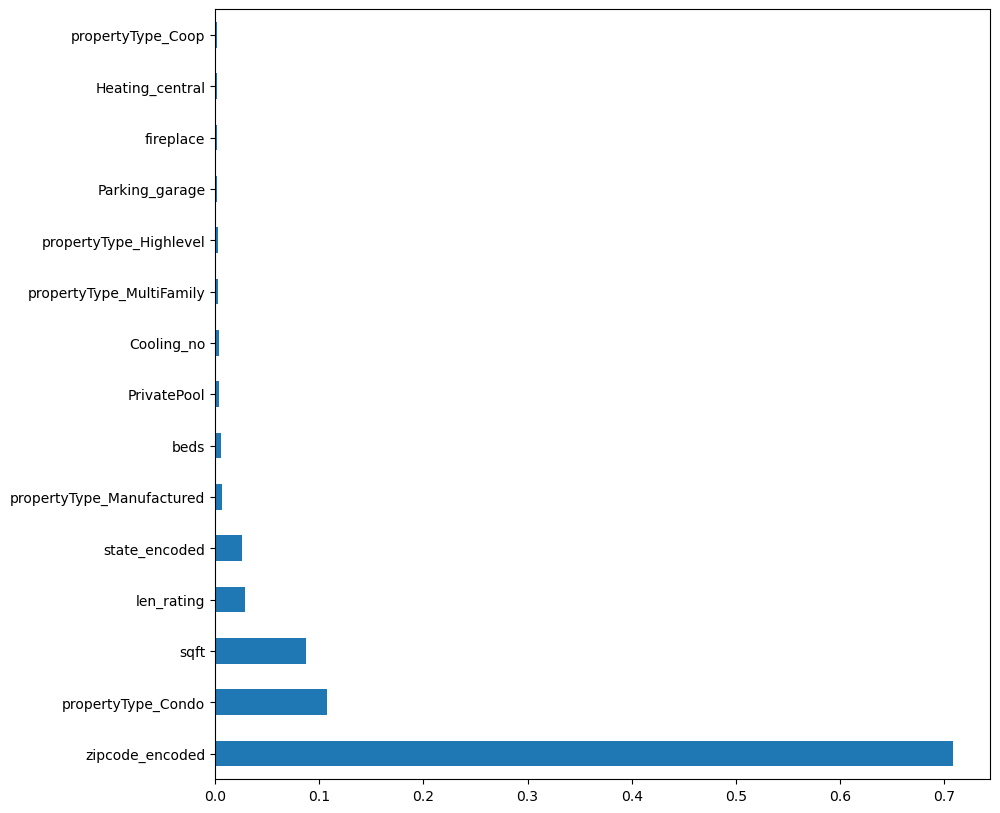

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(rf_regressor.feature_importances_, index=X_scaled.columns)
feat_importances.nlargest(15).plot(kind='barh') 

In [55]:
# выделим 15 самых важных факторов
rf_best = feat_importances.nlargest(15)
rf_best

zipcode_encoded              0.708563
propertyType_Condo           0.107583
sqft                         0.086972
len_rating                   0.028488
state_encoded                0.025572
propertyType_Manufactured    0.006334
beds                         0.005309
PrivatePool                  0.003851
Cooling_no                   0.003327
propertyType_MultiFamily     0.002493
propertyType_Highlevel       0.002463
Parking_garage               0.002166
fireplace                    0.002149
Heating_central              0.002112
propertyType_Coop            0.002018
dtype: float64

- Сначала я создала модель с настройками по умолчанию, но по метрикам присутствует переобучение, поэтому, я ввела ограничивающие факторы, такие как увеличение числа деревьев, количество листьев и глубина дерева. Значения метрик немного снизились, но выровнялись. Так же видим, что эта модель показывает гораздо лучшие результаты. Модель улавливает сложные зависимости в данных. 
- По поводу отобранных признаков, в пятерке лидеров снова индекс, площадь, штат, количество школ и спален. 

In [56]:
# # Создаем экземпляр модели RandomForestRegressor
# rf_regressor_tf = RandomForestRegressor(random_state=RANDOM_SEED)

# # Определяем сетку гиперпараметров для перебора
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [2, 4]
# }

# # Создаем объект GridSearchCV для перебора гиперпараметров
# grid_search = GridSearchCV(estimator=rf_regressor_tf, param_grid=param_grid, cv=5,
#                            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
#                            return_train_score=True,
#                            refit='neg_mean_squared_error')

# # Обучаем модель и выполняем поиск лучших гиперпараметров
# grid_search.fit(X_scaled, y)

# # Получаем лучшую модель и ее оценки метрик
# best_model = grid_search.best_estimator_

# # Извлекаем результаты обучения и тестирования
# results = grid_search.cv_results_
# mse_train = -results['mean_train_neg_mean_squared_error'][grid_search.best_index_]
# mse_test = -results['mean_test_neg_mean_squared_error'][grid_search.best_index_]
# mae_train = -results['mean_train_neg_mean_absolute_error'][grid_search.best_index_]
# mae_test = -results['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
# r2_train = results['mean_train_r2'][grid_search.best_index_]
# r2_test = results['mean_test_r2'][grid_search.best_index_]

# # Выводим метрики
# print(f"Best Train MSE: {mse_train:.2f}")
# print(f"Best Test MSE: {mse_test:.2f}")
# print(f"Best Train MAE: {mae_train:.2f}")
# print(f"Best Test MAE: {mae_test:.2f}")
# print(f"Best Train R2: {r2_train:.2f}")
# print(f"Best Test R2: {r2_test:.2f}")

Считала, считала и насчитала тоже самое, что и предыдущая модель:
- Best Train MSE: 16418.23
- Best Test MSE: 17695.45
- Best Train MAE: 76.69
- Best Test MAE: 78.48
- Best Train R2: 0.69
- Best Test R2: 0.67

Проект учебный, поэтому, главное попробовать, чтобы сравнить результаты. 

Раз у нас RandomForestRegressor дает лучшие результаты, посчитаем более сложную модель, но только на тех факторах, которые RandomForestRegressor посчитала самыми важными.
Попробуем другие модели на основе деревьев. Например:

In [57]:
# Сщздадим ДФ из 15 признаков, которые RandomForestRegressor считает самыми важными 
X_rf = X_scaled[rf_best.index].copy()

In [58]:
# делим общую базу на тренировочную и тестовую
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Gradient Boosting

Модели градиентного бустинга, такие как GradientBoostingRegressor из scikit-learn или XGBoost, представляют собой ансамбли деревьев решений, которые строятся последовательно с учетом ошибок предыдущих моделей. Они могут быть более мощными и точными, чем RandomForestRegressor, но требуют тщательной настройки гиперпараметров. Градиентный бустинг обладает хорошей обобщающей способностью и может обрабатывать сложные зависимости в данных.

In [59]:
# обучим простую модель на всех данных

model = GradientBoostingRegressor(loss='huber', learning_rate=0.1, n_estimators=100, max_depth=3)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R2:", r2_train)
print("Test R2:", r2_test)

Train MSE: 24977.29523327798
Test MSE: 24973.00315772942
Train MAE: 88.28393828537911
Test MAE: 88.10805916166821
Train R2: 0.5293607466235157
Test R2: 0.5291691085420379


Понятно, что модель ограничена по параметрам. Попробуем добавить, хотя бы минимум, и обучим только на тех факторах, которые RandomForestRegressor считает самыми важными.

In [60]:
# # зададим сетку параметров и модель
# param_grid = {
#     'loss': ['huber', 'squared_error'],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [50, 100],
#     'max_depth': [3, 5]
# }
# model = GradientBoostingRegressor()

In [61]:
# # применим к данным
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
# start_time = time.time()
# grid_search.fit(X_train_rf, y_train_rf)
# end_time = time.time()
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)
# print("Execution Time:", end_time - start_time, "seconds")

Best Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 100}
Best Score: -18056.84038677639
Execution Time: 1240.3188905715942 seconds

In [62]:
# # обучим новую модель с лучшими параметрами и выведем метрики
# model = GradientBoostingRegressor(**best_params)

# model.fit(X_train_rf, y_train_rf)

# y_train_pred = model.predict(X_train_rf)
# y_test_pred = model.predict(X_test_rf)

# mse_train = mean_squared_error(y_train_rf, y_train_pred)
# mse_test = mean_squared_error(y_test_rf, y_test_pred)
# mae_train = mean_absolute_error(y_train_rf, y_train_pred)
# mae_test = mean_absolute_error(y_test_rf, y_test_pred)
# r2_train = r2_score(y_train_rf, y_train_pred)
# r2_test = r2_score(y_test_rf, y_test_pred)

# print("Train MSE:", mse_train)
# print("Test MSE:", mse_test)
# print("Train MAE:", mae_train)
# print("Test MAE:", mae_test)
# print("Train R2:", r2_train)
# print("Test R2:", r2_test)

Зафиксировали параметры закомментим модель. Т.к работа занимает большое количество времени. 

- Train MSE: 17595.71742648984
- Test MSE: 18011.88451464409
- Train MAE: 77.9548436894486
- Test MAE: 78.36488583980055
- Train R2: 0.6684494764191504
- Test R2: 0.6604112212974708

По сравнению с RandomForestRegressor улучшение очень маленькой, сотые. Возможно, если бы использовались все факторы данные были бы лучше. 

## ExtraTreesRegressor

ExtraTreesRegressor (Extra Trees) также является ансамблем деревьев решений, похожим на RandomForestRegressor. Он отличается в том, что использует случайные разбиения при построении каждого дерева, в отличие от случайных выборов признаков в RandomForestRegressor. Это может привести к еще большей разнообразности моделей и улучшению обобщающей способности. Extra Trees также может быть эффективным для работы с выбросами и шумом в данных.

In [71]:
# создадим модель
model = ExtraTreesRegressor(random_state=RANDOM_SEED, 
                            n_estimators=200,  # Увеличение количества деревьев
                            max_depth=15,  # Ограничение глубины деревьев
                            min_samples_split=10,  # Минимальное количество образцов для разделения узла
                            min_samples_leaf=5)  # Минимальное количество образцов в листе дерева


# начало выполнения
start_time = time.time()

# тренируем модель
model.fit(X_train, y_train)

# конец выполнения
end_time = time.time()

# Make predictions on training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# выводим результат
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R2:", r2_train)
print("Test R2:", r2_test)

# время модели
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

Train MSE: 16194.263897249935
Test MSE: 18229.494815600166
Train MAE: 74.77744086291545
Test MAE: 78.30462389128024
Train R2: 0.6948566208470439
Test R2: 0.6563084847806626
Execution Time: 176.97563314437866 seconds


Модель по умолчанию показывает небольшое переобучение, поэтому в модели выше введены ограничивающие факторы, такие как количество делевьев, глубина, количество листьев. Переобучение немного снизилось.

## AdaBoost

AdaBoost: AdaBoostRegressor (AdaBoost) - это алгоритм адаптивного бустинга, который также использует ансамбль деревьев решений. Он работает путем последовательного обучения моделей на данных с весами, присваивая больший вес неправильно классифицированным образцам на каждой итерации. AdaBoost может быть эффективным, особенно в случаях, когда данные имеют шум или сложные зависимости. Он также может быть устойчивым к переобучению и способен хорошо работать с выбросами.

In [73]:
# бустинг
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train, y_train)

y_train_predict  = ada.predict(X_train)
y_test_predict = ada.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R2:", r2_train)
print("Test R2:", r2_test)

/home/tatiana/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train MSE: 16194.263897249935
Test MSE: 18229.494815600166
Train MAE: 74.77744086291545
Test MAE: 78.30462389128024
Train R2: 0.6948566208470439
Test R2: 0.6563084847806626


## LightGBM

LightGBM - это библиотека градиентного бустинга, которая также представляет собой ансамбль деревьев решений. Она разработана для эффективной работы с большими объемами данных и имеет высокую скорость обучения и прогнозирования. LightGBM использует алгоритмы оптимизации и сжатие данных, что делает его особенно полезным в задачах с большим количеством признаков или категориальных переменных.

In [82]:
# Задаем сетку параметров для модели
params = {
    'objective': 'regression',
    'metric': ['mse', 'mae', 'r2'],
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
}

# задаем трейн и тест датасет 
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# обучаем модель
model = lgb.train(params, train_data)

# делаем предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# выводим метрики
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R2:", r2_train)
print("Test R2:", r2_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 234077, number of used features: 42
[LightGBM] [Info] Start training from score 254.762458
Train MSE: 18059.30751701608
Test MSE: 18508.24702632716
Train MAE: 78.37206203218456
Test MAE: 78.99508122868127
Train R2: 0.6597141953552779
Test R2: 0.6510530034497419


In [85]:
# задаем параметры для LightGBM model
params = {
    'objective': 'regression',
    'metric': ['mse', 'mae', 'r2'],
    'num_leaves': 31,
    'learning_rate': 0.1
}

# создаем датасеты
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# задаем сетку
grid_params = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9]
}

# применяем к модели параметры
model = lgb.LGBMRegressor(**params)

# обучаем на Гдид серч
grid_search = GridSearchCV(model, grid_params, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# лучшие
best_params = grid_search.best_params_

# обновляем значение параметры
params.update(best_params)

# переобучаем модель на лучших параметрах
model = lgb.LGBMRegressor(**params)

# обучаем модель
model.fit(X_train, y_train)

# делаем предсказание 
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# метрики на дренировочном и тестовом датасете
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# выводим
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R2:", r2_train)
print("Test R2:", r2_test)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 187261, number of used features: 42
[LightGBM] [Info] Start training from score 254.889717
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warn

- Train MSE: 15342.122000388348
- Test MSE: 16759.693061646125
- Train MAE: 71.77493251881555
- Test MAE: 73.91295403463694
- Train R2: 0.7109132603816332
- Test R2: 0.6840195320147421